# Importing necessary libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [3]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

     |████████████████████████████████| 2.2 MB 7.4 MB/s            
     |████████████████████████████████| 1.3 MB 49.1 MB/s            


In [4]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import sys
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Helper functions for pytorch dataloaders

In [7]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [8]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=5),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
#             T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [9]:
# path of the database
dataset_path = "alcohol-3/train_test_split/train_test_split"

In [10]:
# loading a batch of 128 for training purpose while a batch of 32 for testing and validation 
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [11]:
classes = get_classes("alcohol-3/train_test_split/train_test_split/train")
print(len(classes))

2


In [12]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [13]:
print(len(train_loader), len(val_loader), len(test_loader))

175 219 220


In [14]:
print(train_data_len, valid_data_len, test_data_len)

22307 7004 7011


### Thus, there are 22307 train, 7004 validation and 7011 testing images.

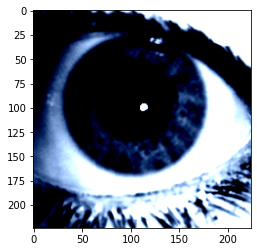

In [15]:
# Displaying transformed image
i = 0
for data in train_loader:
    plt.imshow(data[0][24].permute(1,2,0))
    break

In [16]:
# printing the shape
for data in test_loader:
    print(data[0].shape)
    break

torch.Size([32, 3, 224, 224])


In [17]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading the model and adding Feed Forward Neural layer

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

In [19]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

# n_inputs = model.head.in_features 
model.head = nn.Sequential(
    nn.Linear(192, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.Linear(128, 32),
    nn.Linear(32,len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): Linear(in_features=32, out_features=2, bias=True)
)


# Defining the hyper-parameters of the model

In [20]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [21]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# Training the model

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [23]:
# for removing error while loading image using PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [24]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster

Epoch 0/14
----------


100%|██████████| 175/175 [02:15<00:00,  1.29it/s]


train Loss: 0.4153 Acc: 0.8672


100%|██████████| 219/219 [00:36<00:00,  6.02it/s]


val Loss: 0.3558 Acc: 0.8968

Epoch 1/14
----------


100%|██████████| 175/175 [02:02<00:00,  1.43it/s]


train Loss: 0.3517 Acc: 0.9113


100%|██████████| 219/219 [00:31<00:00,  6.93it/s]


val Loss: 0.3145 Acc: 0.9399

Epoch 2/14
----------


100%|██████████| 175/175 [01:58<00:00,  1.47it/s]


train Loss: 0.3196 Acc: 0.9349


100%|██████████| 219/219 [00:32<00:00,  6.81it/s]


val Loss: 0.2912 Acc: 0.9567

Epoch 3/14
----------


100%|██████████| 175/175 [02:00<00:00,  1.45it/s]


train Loss: 0.3025 Acc: 0.9473


100%|██████████| 219/219 [00:31<00:00,  7.00it/s]


val Loss: 0.2819 Acc: 0.9643

Epoch 4/14
----------


100%|██████████| 175/175 [02:00<00:00,  1.46it/s]


train Loss: 0.2899 Acc: 0.9562


100%|██████████| 219/219 [00:31<00:00,  6.94it/s]


val Loss: 0.2741 Acc: 0.9700

Epoch 5/14
----------


100%|██████████| 175/175 [01:58<00:00,  1.47it/s]


train Loss: 0.2815 Acc: 0.9624


100%|██████████| 219/219 [00:31<00:00,  6.93it/s]


val Loss: 0.2650 Acc: 0.9696

Epoch 6/14
----------


100%|██████████| 175/175 [01:58<00:00,  1.47it/s]


train Loss: 0.2744 Acc: 0.9656


100%|██████████| 219/219 [00:31<00:00,  6.90it/s]


val Loss: 0.2577 Acc: 0.9770

Epoch 7/14
----------


100%|██████████| 175/175 [01:57<00:00,  1.48it/s]


train Loss: 0.2706 Acc: 0.9700


100%|██████████| 219/219 [00:32<00:00,  6.82it/s]


val Loss: 0.2590 Acc: 0.9747

Epoch 8/14
----------


100%|██████████| 175/175 [01:59<00:00,  1.46it/s]


train Loss: 0.2687 Acc: 0.9699


100%|██████████| 219/219 [00:32<00:00,  6.81it/s]


val Loss: 0.2552 Acc: 0.9776

Epoch 9/14
----------


100%|██████████| 175/175 [01:58<00:00,  1.48it/s]


train Loss: 0.2620 Acc: 0.9740


100%|██████████| 219/219 [00:31<00:00,  6.92it/s]


val Loss: 0.2534 Acc: 0.9769

Epoch 10/14
----------


100%|██████████| 175/175 [01:59<00:00,  1.46it/s]


train Loss: 0.2611 Acc: 0.9751


100%|██████████| 219/219 [00:31<00:00,  6.87it/s]


val Loss: 0.2504 Acc: 0.9799

Epoch 11/14
----------


100%|██████████| 175/175 [02:01<00:00,  1.44it/s]


train Loss: 0.2589 Acc: 0.9753


100%|██████████| 219/219 [00:31<00:00,  6.87it/s]


val Loss: 0.2518 Acc: 0.9773

Epoch 12/14
----------


100%|██████████| 175/175 [01:59<00:00,  1.46it/s]


train Loss: 0.2555 Acc: 0.9774


100%|██████████| 219/219 [00:31<00:00,  6.87it/s]


val Loss: 0.2443 Acc: 0.9829

Epoch 13/14
----------


100%|██████████| 175/175 [01:59<00:00,  1.47it/s]


train Loss: 0.2550 Acc: 0.9773


100%|██████████| 219/219 [00:31<00:00,  6.91it/s]


val Loss: 0.2446 Acc: 0.9829

Epoch 14/14
----------


100%|██████████| 175/175 [02:00<00:00,  1.46it/s]


train Loss: 0.2539 Acc: 0.9774


100%|██████████| 219/219 [00:31<00:00,  6.86it/s]

val Loss: 0.2452 Acc: 0.9820

Training complete in 38m 14s
Best Val Acc: 0.9829


We achieved a validation accuracy of 98.29% with a training time of 38 mins and 14 sec.

# Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [25]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of alcoholic class: %2d%% (%2d/%2d)" % (
             100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of non-alcoholic class: %2d%% (%2d/%2d)" % (
             100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        )) 
        
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 220/220 [00:37<00:00,  5.93it/s]

Test Loss: 0.0001
Test Accuracy of alcoholic class: 96% (3436/3544)
Test Accuracy of alcoholic class: 99% (3446/3464)
Test Accuracy of 98% (6882/7008)


Our model finally earned a 98% test accuracy. 

# Evaluating on a random image

-> For inference purposes

In [26]:
for i in test_loader:
    random_img = i[0][14]
    break
random_img.shape

torch.Size([3, 224, 224])

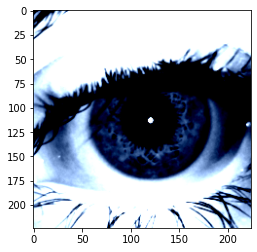

In [27]:
arr_ = np.array(random_img.permute(1,2,0))
plt.imshow(arr_)
plt.show()

In [28]:
# predicted class label
random_img = random_img.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    class_index = model(random_img).argmax()
    print(class_index)

tensor(1, device='cuda:0')


In [29]:
# true class label
i[1][14]

tensor(1)

Thus, our model is predicting correctly on an inference images too.

# Quantizing and scripting the model

Applying dynamic quantization to reduce the size of trained model while ensuring accuracy remains same.
Using fbgemm backend for x86 CPU. After that, scripting is done to convert pytorch model to Torchscript model.

### Note : Pytorch 1.9.1 do not support quantized operator implementation on CUDA, so we need to transfer model back to cpu for quantization.

In [30]:
backend = 'fbgemm'
model_quant_config = torch.quantization.get_default_qconfig(backend)
print(model_quant_config)

QConfig(activation=functools.partial(<class 'torch.quantization.observer.HistogramObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric))


In [31]:
torch.backends.quantized.engine = backend
quantized_model = torch.quantization.quantize_dynamic(model.to('cpu'), qconfig_spec={torch.nn.Linear}, dtype=torch.float16)

In [32]:
# Utilizing a Just In Compiler(jit) to script the quantized model
script_quantized_model = torch.jit.script(quantized_model.cpu())
script_quantized_model.save("alcohol_deit_video.pt")

# Optimizing the model

### Running a list of optimization pass with modules in evaluation mode. This improves the model overall graph for better optimizationm. Following is the optimization list applied :
    1 -> Freezing the useless attributes of the module
    2 -> Inlining the function to remove function call overhead
    3 -> Fusing the intermediate layers such as conv-batchnorm or conv-relu
    4 -> Removing the Dropout to improve the performance of the model

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile
scripted_quantized_model = torch.load(r'weights/alcohol_deit_video (2).pt')

In [5]:
optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("alcohol_deit_optimized.pt")

# Saving for inference on lite interpreter devices such as mobile 

Adding mobile specific bytecode to the optimized Torchscript model to produce the lite interpreter model. Doing this ensures that PyTorch saves additional bytecode for the model’s graph, which is more efficient to execute on device compared to TorchScript. PyTorch also uses lesser binary size in the compiled app relative to running TorchScript.

In [6]:
optimized_scripted_quantized_model._save_for_lite_interpreter('alcohol_deit_optimized_lite.ptl')